In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install imutils
!pip install -q tensorflow-model-optimization

import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import numpy as np 
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=6a6befd4fbcd8700052d5fc82a82c9715160be3561552d5a9939ac94ae8a7ff0
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#KERAS LIB FOR CNN
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

#lIBRARIES
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

Folder join

In [4]:
X_train = []
Y_train = []
image_size = 200
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('/kaggle/input/braintumor-augmented/Imagedataset/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/braintumor-augmented/Imagedataset/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [5]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(15264, 200, 200, 3)

Train TEST SPLIT

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

CNN

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_model_optimization.sparsity import keras as sparsity

from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True
    
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [9]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [10]:
train_len = len(X_train)
val_len = len(X_test)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
12211
-----------Validation Data length-----------------
3053


In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=64, epochs=40, callbacks=callbacks)

Epoch 1/40
191/191 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8905
Epoch 1: val_loss improved from inf to 0.39488, saving model to .mdl_wts.hdf5
191/191 [==============================] - 109s 329ms/step - loss: 0.3010 - accuracy: 0.8905 - val_loss: 0.3949 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 2/40
191/191 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9874
Epoch 2: val_loss improved from 0.39488 to 0.27158, saving model to .mdl_wts.hdf5
191/191 [==============================] - 59s 312ms/step - loss: 0.0378 - accuracy: 0.9874 - val_loss: 0.2716 - val_accuracy: 0.9086 - lr: 1.0000e-04
Epoch 3/40
191/191 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9912
Epoch 3: val_loss improved from 0.27158 to 0.09191, saving model to .mdl_wts.hdf5
191/191 [==============================] - 58s 306ms/step - loss: 0.0276 - accuracy: 0.9912 - val_loss: 0.0919 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 4/40
191/1

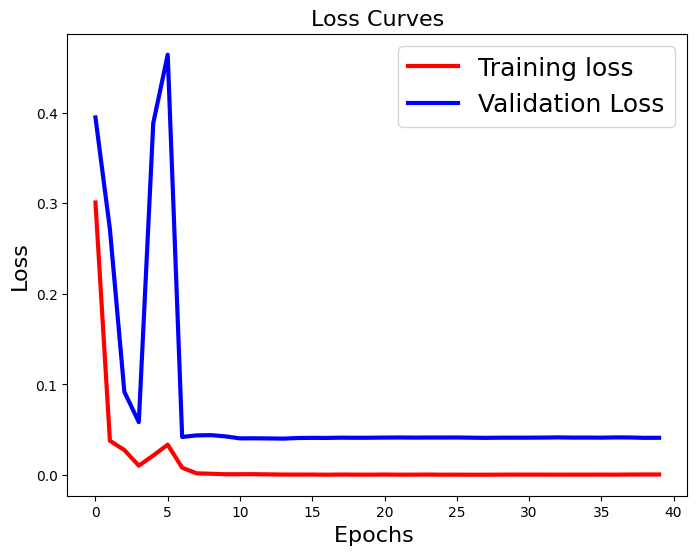

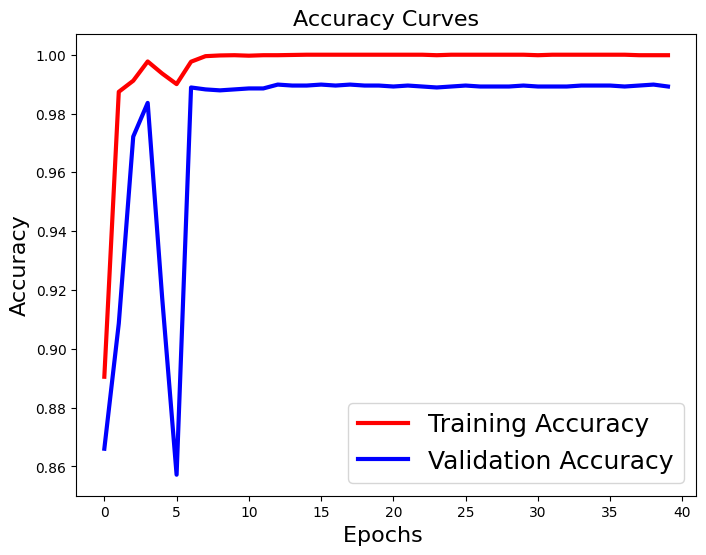

Baseline test accuracy: [0.04110448434948921, 0.989190936088562]
Saved baseline model to: /tmp/tmp_p8_3okt.h5


In [12]:

import tempfile
import tensorflow as tf

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

baseline_model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)


keras_file = tempfile.mktemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)


In [13]:
import seaborn as sns
predicted_classes = np.argmax(model.predict(X_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
model.save('braintumor.h5')

model = load_model('/kaggle/working/braintumor.h5')
loss,acc = model.evaluate(X_test,y_test)


96/96 [==============================] - 5s 44ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       765
  meningioma       0.98      0.98      0.98       791
    no_tumor       1.00      1.00      1.00       724
   pituitary       0.99      1.00      0.99       773

    accuracy                           0.99      3053
   macro avg       0.99      0.99      0.99      3053
weighted avg       0.99      0.99      0.99      3053

96/96 [==============================] - 6s 49ms/step - loss: 0.0411 - accuracy: 0.9892


saving model and evaluating 

In [22]:
!pip install -q tensorflow-model-optimization
from tensorflow_model_optimization.sparsity import keras as sparsity
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)
# Remove pruning wrappers to get the pruned model
model_for_pruning = sparsity.strip_pruning(pruned_model)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[3][0]']              
                                )                                                                 
                                                                                              

In [23]:
history = pruned_model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=64, epochs=45, callbacks=callbacks)

Epoch 1/45
191/191 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9552
Epoch 1: val_loss did not improve from 0.04018
191/191 [==============================] - 95s 366ms/step - loss: 0.1455 - accuracy: 0.9552 - val_loss: 0.2745 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 2/45
191/191 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9880
Epoch 2: val_loss did not improve from 0.04018
191/191 [==============================] - 67s 352ms/step - loss: 0.0386 - accuracy: 0.9880 - val_loss: 0.2511 - val_accuracy: 0.9188 - lr: 0.0010
Epoch 3/45
191/191 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9930
Epoch 3: val_loss did not improve from 0.04018
191/191 [==============================] - 66s 347ms/step - loss: 0.0217 - accuracy: 0.9930 - val_loss: 1.2468 - val_accuracy: 0.7026 - lr: 0.0010
Epoch 4/45
191/191 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9922
Epoch 4: val_loss did not improve 

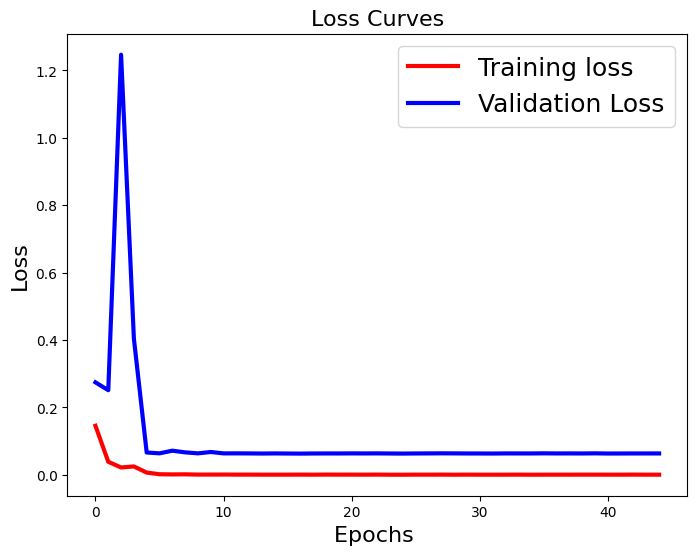

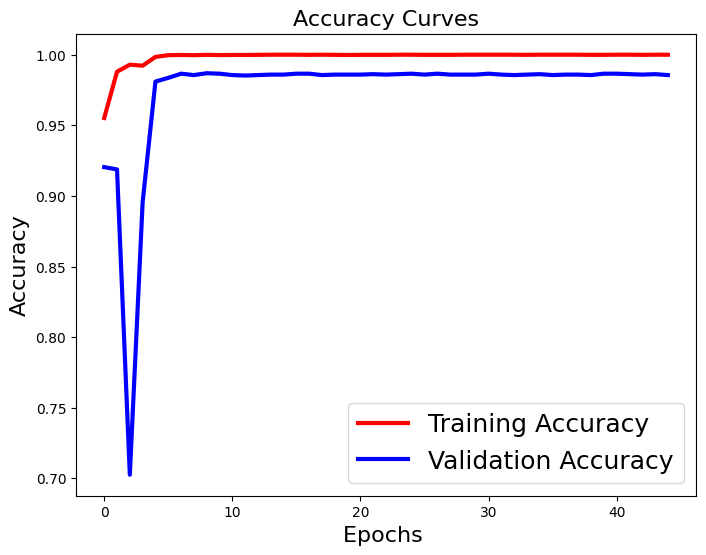

Baseline test accuracy: [0.06338299810886383, 0.9855879545211792]
Saved baseline model to: /tmp/tmpjnhh78rk.h5


In [24]:

import tempfile
import tensorflow as tf

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

baseline_model_accuracy = pruned_model.evaluate(X_test, y_test, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)


keras_file = tempfile.mktemp('.h5')
tf.keras.models.save_model(pruned_model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
pruned_model.save('prunedbraintumor.h5')

model = load_model('/kaggle/working/prunedbraintumor.h5')
loss,acc = model.evaluate(X_test,y_test)

ValueError: Unknown layer: 'PruneLowMagnitude'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
import itertools
pred_Y = model.predict(X_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

epochs = [i for i in range(60)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()